In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import math

from glob import glob

In [2]:
# DATA_DIR = '/scratch2/heneka/21cmlightcones/pure_simulations'
DATA_DIR = '/remote/gpu01a/heneka/21cmlightcones/pure_simulations'

files = glob(f'{DATA_DIR}/*.npz')

In [3]:
SHAPE = [140, 140, 2350]
RESHAPE_2 = [r for s in SHAPE for r in [s//2, 2]]
RESHAPE_5 = [r for s in SHAPE for r in [s//5, 5]]

In [4]:
x = np.load(files[0])['image']
rand_int = int(np.random.rand()*3)
x1 = np.rot90(x, np.random.rand(), axes=(1,0))
x2 = np.rot90(x, 2, axes=(1,0))
x3 = np.rot90(x, 3, axes=(1,0))
x4 = np.rot90(x, 4, axes=(1,0))

y2 = np.mean(x.reshape(*RESHAPE_2), axis=(1, 3, 5))
y5 = np.mean(x.reshape(*RESHAPE_5), axis=(1, 3, 5))  

x.shape

(140, 140, 2350)

In [5]:
from einops import rearrange

patch_shape = [4, 4, 5]
in_channels, *axis_sizes = [1, 28, 28, 470]
num_patches = [s // p for s, p in zip(axis_sizes, patch_shape)]

def to_patches(x):
    x = rearrange(
        x, '(x p1) (y p2) (z p3) -> x y z) (p1 p2 p3)',
        **dict(zip(('p1', 'p2', 'p3'), patch_shape))
    )
    return x

def from_patches(x):
    x = rearrange(
        x, '(x y z) (p1 p2 p3) -> (x p1) (y p2) (z p3)',
        **dict(zip(('x', 'y', 'z', 'p1', 'p2', 'p3'), num_patches+patch_shape))
    )
    return x

In [22]:
import random

mask_frac_scale = [0.2, 0.2]
mask_aspect_scale = [0.75, 1.5]

patch_shape = [4, 4, 5]
in_channels, *axis_sizes = [1, 28, 28, 470]
num_patches = [s // p for s, p in zip(axis_sizes, patch_shape)]

def sample_block_size():
    """
    Helper that samples block mask dimensions
    cfg.mask_frac_scale: interval that a block fraction is sampled from
    cfg.mask_aspect_scale: interval that x and y ratio is sampled from
    """
    max_dims = num_patches

    # Sample cube volume ie. mask fraction
    min_s, max_s = mask_frac_scale
    v = random.uniform(min_s, max_s)

    # Sample two aspect-ratios, between z & x and z & y respectively
    def sample_aspect_ratio():
        # Sample a single aspect-ratio, ensuring that both dimensions are equally likely to be scaled up or down
        min_ar, max_ar = mask_aspect_scale
        if torch.randint(0, 2, (1,)) == 0:
            max_ar = 1.
        else:
            min_ar = 1.
        aspect_ratio = (min_ar - max_ar) * torch.rand(1,) + max_ar
        return aspect_ratio

    while True:
        # Sample ratios such that all dimensions are restricted to within a unit cube
        ratio_h = sample_aspect_ratio()
        ratio_w = sample_aspect_ratio()
        d = math.cbrt(v / (ratio_h * ratio_w))
        h = ratio_h * d
        w = ratio_w * d
        dims = [h, w, d]
        dim_outside = [dim > 1. for dim in dims]
        if not any(dim_outside): break

    # Scale unit cube dimensions to number of patches
    for j in range(len(dims)):
        dims[j] = int(dims[j] * max_dims[j] + .5)
    
    return dims

In [7]:
def sample_block_mask():
    """
    Helper that samples boolean block mask
    TODO: ensure that blocks shapes are sampled 
    """
    height, width, depth = num_patches
    h, w, d = sample_block_size()

    # Loop to sample masks until we find a valid one
    tries = 0
    timeout = 20
    valid_mask = False
    while not valid_mask:
        # Sample block top-left corner
        top = torch.randint(0, height - h + 1, (1,))
        left = torch.randint(0, width - w + 1, (1,))
        back = torch.randint(0, depth - d + 1, (1,))
        mask_map = torch.zeros((height, width, depth), dtype=torch.int32)
        mask_map[top:top+h, left:left+w, back:back+d] = 1
        #mask_map = mask_map.flatten()
        # If mask too small try again
        min_keep = 4 # minimum number of patches to keep
        valid_mask = len(mask_map) > min_keep
        if not valid_mask:
            timeout -= 1
            if timeout == 0:
                tries += 1
                timeout = og_timeout
    mask_map = mask_map.squeeze().bool()
    return mask_map

In [8]:
'''print(num_patches)
for i in range(20):
    print(sample_block_mask())'''

'print(num_patches)\nfor i in range(20):\n    print(sample_block_mask())'

In [9]:
iterations = 1000
sizes = np.array([0,0,0])
for i in range (iterations):
    sizes += sample_block_size()
mean_blocks = np.array(sizes)/iterations/num_patches
print(mean_blocks)
print(math.prod(mean_blocks)/np.mean(mask_frac_scale))
#print(sample_block_size())

[0.746      0.74728571 0.75489362]
1.0520860674772035


In [10]:
# fixes asymmetrical sampling
mask_aspect_scale = [0.3, 3]
ratios = []
for i in range (100000):
    min_ar, max_ar = mask_aspect_scale
    if torch.rand(1,) < .5:
        max_ar = 1
    else:
        min_ar = 1
    aspect_ratio = (min_ar - max_ar) * torch.rand(1,) + max_ar
    ratios.append(aspect_ratio > 1)
np.mean(np.array(ratios))

0.49946

In [11]:
# old version
mask_aspect_scale = [0.3, 3.0]
min_ar, max_ar = mask_aspect_scale
ratios = []
for i in range (1000):
    aspect_ratio = (min_ar - max_ar) * torch.rand(1,) + max_ar
    ratios.append(aspect_ratio > 1)
np.mean(np.array(ratios))

0.728

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_boolean_tensor_3d(tensor):
    if not tensor.dtype == torch.bool:
        raise ValueError("The input tensor must be a boolean tensor")
    if len(tensor.shape) != 3:
        raise ValueError("The input tensor must have 3 dimensions")
    
    num_slices = tensor.shape[2]
    
    # Determine grid size for plotting
    ncols = int(np.ceil(np.sqrt(num_slices)))
    nrows = int(np.ceil(num_slices / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_slices):
        ax = axes[i]
        slice_2d = tensor[:, :, i].numpy()
        cax = ax.matshow(slice_2d, cmap='Greys')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Slice {i+1}')
    
    # Hide any unused subplots
    for i in range(num_slices, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [13]:
def visualize_boolean_tensor_3d(tensor):
    if not tensor.dtype == torch.bool:
        raise ValueError("The input tensor must be a boolean tensor")
    if len(tensor.shape) != 3:
        raise ValueError("The input tensor must have 3 dimensions")
    
    num_slices = tensor.shape[2]
    
    # Determine grid size for plotting
    ncols = int(np.ceil(np.sqrt(num_slices)))
    nrows = int(np.ceil(num_slices / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_slices):
        ax = axes[i]
        slice_2d = tensor[:, :, i].numpy()
        cax = ax.matshow(slice_2d, cmap='Greys')
        
        # Setting x and y ticks
        ax.set_xticks(np.arange(slice_2d.shape[1]))
        ax.set_yticks(np.arange(slice_2d.shape[0]))
        
        # Optional: To label the ticks with their indices
        ax.set_xticklabels(np.arange(slice_2d.shape[1]))
        ax.set_yticklabels(np.arange(slice_2d.shape[0]))
        
        ax.set_title(f'Slice {i+1}')
    
    # Hide any unused subplots
    for i in range(num_slices, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

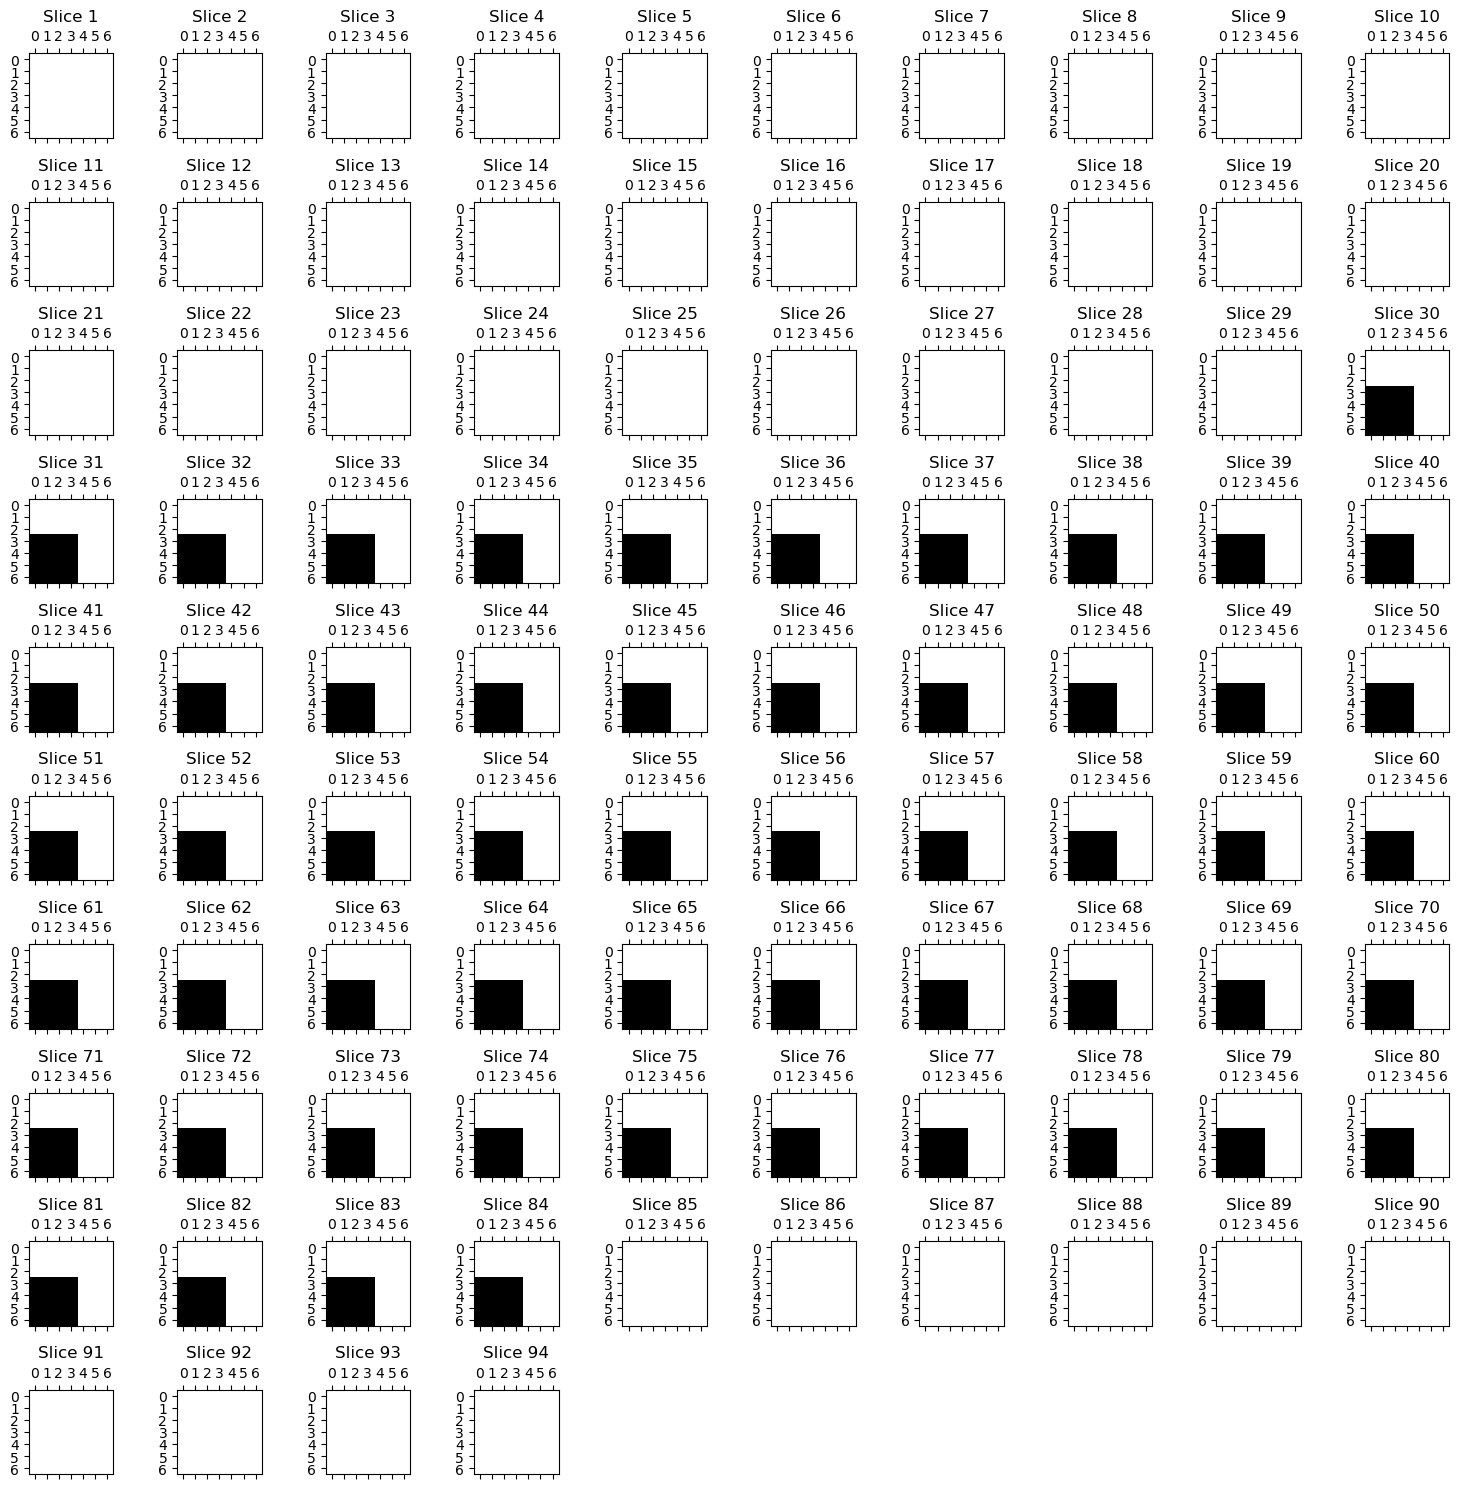

In [27]:
mask = sample_block_mask()
visualize_boolean_tensor_3d(mask)

In [26]:
def visualize_boolean_tensor(tensor):
    if not tensor.dtype == torch.bool:
        raise ValueError("The input tensor must be a boolean tensor")
    
    # Convert the tensor to a numpy array
    tensor_np = tensor.numpy()
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create a heatmap using the numpy array
    cax = ax.matshow(tensor_np, cmap='Greys')
    
    # Set axis labels
    ax.set_xticks(np.arange(tensor_np.shape[1]))
    ax.set_yticks(np.arange(tensor_np.shape[0]))
    
    # Show the plot
    plt.show()

In [16]:
mask.shape

torch.Size([7, 7, 94])

TypeError: Invalid shape (7, 7, 94) for image data

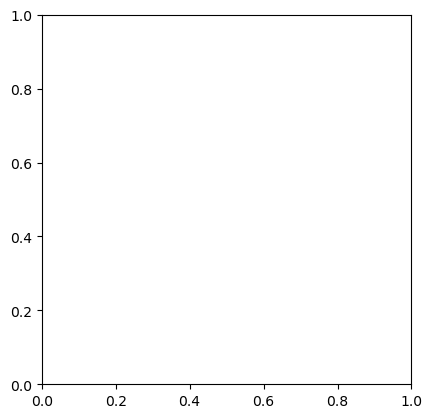

In [17]:
visualize_boolean_tensor(mask)

In [ ]:

#sample_block_mask(x)
to_patches(x).shape
#from_patches(x)

In [ ]:
def compare_rotations(idx):
    fig, ax = plt.subplots(1, 5, figsize=(12, 4))
    
    ax[0].imshow(x[:, :, idx])
    ax[1].imshow(x1[:, :, idx])
    ax[2].imshow(x2[:, :, idx])
    ax[3].imshow(x3[:, :, idx])
    ax[4].imshow(x4[:, :, idx])

    ax[0].set_title('Original')
    ax[1].set_title('90')
    ax[2].set_title('180')
    ax[3].set_title('270')
    ax[4].set_title('360')
    ax[4].set_title(rand_int*90)
compare_rotations(1000)

In [ ]:
def compare_resolutions(idx):
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    
    ax[0].imshow(x[:, :, idx])
    ax[1].imshow(y2[:, :, idx//2])
    ax[2].imshow(y5[:, :, idx//5])
    ax[3].imshow(x1[:, :, idx])

    ax[0].set_title('Original')
    ax[1].set_title('x2')
    ax[2].set_title('x5')
    ax[3].set_title('Rotated')
    

In [ ]:
compare_resolutions(1000)

In [ ]:
compare_resolutions(1200)

In [ ]:
compare_resolutions(2000)

In [ ]:
compare_resolutions(-1)